In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

Mounted at /content/gdrive


In [ ]:
#https://www.kaggle.com/youssefgdv/alzheimer-s-disease-classification-inceptionv3
#!unzip gdrive/MyDrive/alzheimers_data.zip

In [2]:

from zipfile import ZipFile
file_name = "alzheimers_data.zip"

with ZipFile(file_name, 'r') as zip1:
  zip1.extractall()
  print('Done')


Done


In [2]:
pip install keras_efficientnets

In [3]:
pip install imblearn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

!pip install -U tensorflow-addons==0.11.2
#from tensorflow.keras.applications import EfficientNetB7
#from keras_efficientnets import EfficientNetB7
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

Requirement already up-to-date: tensorflow-addons==0.11.2 in c:\users\hp\anaconda3\lib\site-packages (0.11.2)
TensorFlow Version: 2.2.0


In [4]:
!python --version

Python 3.8.5


In [12]:
!pip install -U efficientnet

Requirement already up-to-date: efficientnet in c:\users\hp\anaconda3\lib\site-packages (1.1.1)


In [8]:
import efficientnet.keras as effnet

In [16]:
pip install cloud_tpu_client

Note: you may need to restart the kernel to use updated packages.


In [18]:
'''
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
'''

'\nfrom cloud_tpu_client import Client\nc = Client()\nc.configure_tpu_version(tf.__version__, restart_type="always")\n'

### Data Pre-Processing

In [5]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
WORK_DIR = './dataset/'
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [8]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [7]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    


In [25]:
#Display train images
show_images(train_data_gen)

NameError: name 'test_data_gen' is not defined

In [9]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [10]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-ace47b1fb69e>", line 5, in <module>
    train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
  File "C:\Users\HP\anaconda3\lib\site-packages\imblearn\base.py", line 83, in fit_resample
    output = self._fit_resample(X, y)
  File "C:\Users\HP\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py", line 324, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 752, in kneighbors
    chunked_results = list(
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1717, in pairwise_distances_chunked
    D_chunk = pairwise_distances(X_chunk, Y, metric=metric, n_jobs=n_

TypeError: object of type 'NoneType' has no len()

In [10]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Constructing a Convolutional Neural Network Architecture

In [5]:

def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block


In [6]:

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block


In [9]:
premodel = effnet.EfficientNetB7(include_top=True, weights="imagenet", drop_connect_rate=0.2, input_tensor=Input(shape=(176, 176, 3)))

In [14]:
premodel.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 176, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 88, 88, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 88, 88, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 88, 88, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________

block5b_activation (Activation) (None, 11, 11, 1344) 0           block5b_bn[0][0]                 
__________________________________________________________________________________________________
block5b_se_squeeze (GlobalAvera (None, 1344)         0           block5b_activation[0][0]         
__________________________________________________________________________________________________
block5b_se_reshape (Reshape)    (None, 1, 1, 1344)   0           block5b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5b_se_reduce (Conv2D)      (None, 1, 1, 56)     75320       block5b_se_reshape[0][0]         
__________________________________________________________________________________________________
block5b_se_expand (Conv2D)      (None, 1, 1, 1344)   76608       block5b_se_reduce[0][0]          
__________________________________________________________________________________________________
block5b_se

Total params: 66,658,680
Trainable params: 66,347,960
Non-trainable params: 310,720
__________________________________________________________________________________________________


In [10]:
for layer in premodel.layers:
    layer.trainable=False

In [22]:

'''
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.15),
        conv_block(256),
        Dropout(0.15),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")
    
    model = Sequential()
    model.add(premodel)
    #model.add(tf.keras.layers.GlobalMaxPooling2D(name="gap"))
    #model.add(tf.keras.layers.Dropout(dropout_rate=0.2, name="dropout_out"))
    model.add(tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(tf.keras.layers.Dense(4, activation="softmax", name="fc_out"))
    #conv_base.trainable = False
    
    return model
    
'''


In [11]:
model = Sequential([
        premodel,
        Dropout(0.5),
        #GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "efficientnetb7_model")


In [26]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [28]:
#Defining other parameters for our CNN model

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model.summary()
'''
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()
'''

Model: "efficientnetb7_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 1000)              66658680  
_________________________________________________________________
dropout_16 (Dropout)         (None, 1000)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1000)              4000      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               512512    
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)      

"\nmodel = construct_model()\n\nMETRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),\n           tf.keras.metrics.AUC(name='auc'), \n           tfa.metrics.F1Score(num_classes=4)]\n\nCALLBACKS = [my_callback]\n    \nmodel.compile(optimizer='adam',\n              loss=tf.losses.CategoricalCrossentropy(),\n              metrics=METRICS)\n\nmodel.summary()\n"

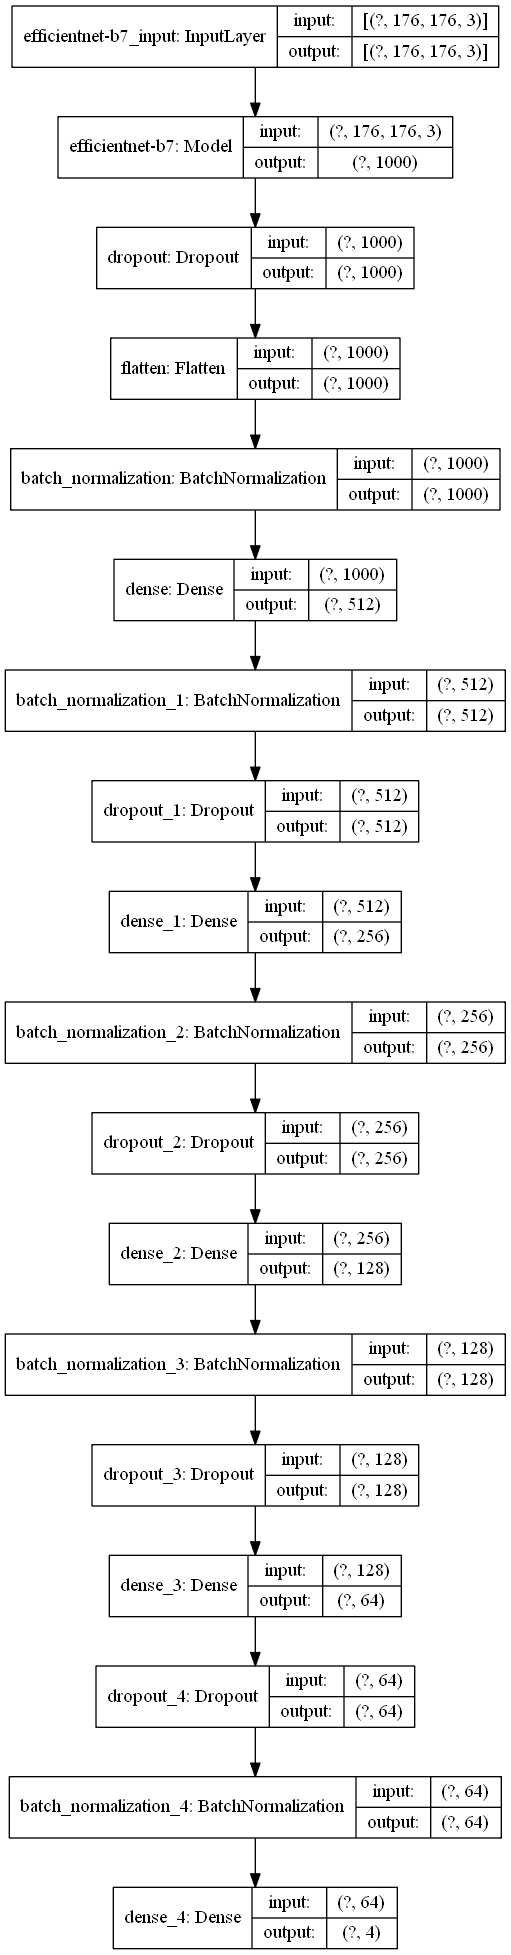

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training & Testing the Model

In [29]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 5

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/5
128/128 [==============================] - 1129s 9s/step - loss: 1.6027 - acc: 0.3328 - auc: 0.5891 - f1_score: 0.2380 - val_loss: 1.1314 - val_acc: 0.5117 - val_auc: 0.7866 - val_f1_score: 0.1693
Epoch 2/5
128/128 [==============================] - 823s 6s/step - loss: 1.2740 - acc: 0.4224 - auc: 0.7129 - f1_score: 0.2471 - val_loss: 1.0524 - val_acc: 0.5117 - val_auc: 0.7842 - val_f1_score: 0.1693
Epoch 3/5
128/128 [==============================] - 727s 6s/step - loss: 1.1671 - acc: 0.4478 - auc: 0.7507 - f1_score: 0.2428 - val_loss: 1.0276 - val_acc: 0.5117 - val_auc: 0.7991 - val_f1_score: 0.1693
Epoch 4/5
128/128 [==============================] - 733s 6s/step - loss: 1.1078 - acc: 0.4624 - auc: 0.7670 - f1_score: 0.2436 - val_loss: 1.0187 - val_acc: 0.5117 - val_auc: 0.7996 - val_f1_score: 0.1693
Epoch 5/5
128/128 [==============================] - 729s 6s/step - loss: 1.0786 - acc: 0.4702 - auc: 0.7754 - f1_score: 0.2328 - val_loss: 1.0020 - val_acc: 0.5146 - val_auc:

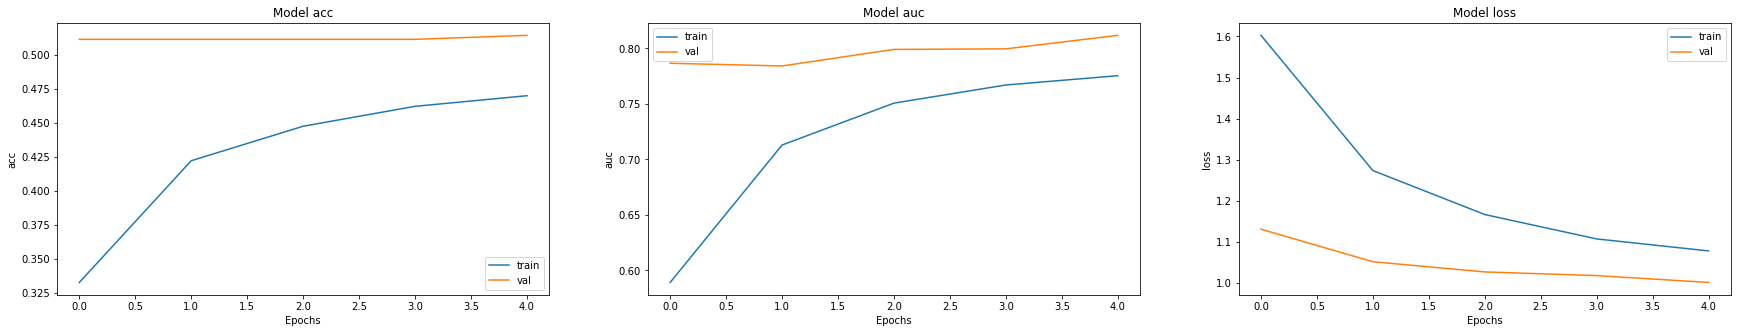

In [30]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [31]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 191s 5s/step - loss: 1.0207 - acc: 0.5055 - auc: 0.8022 - f1_score: 0.1733
Testing Accuracy: 50.55%


In [32]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [33]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.00      0.00      0.00       201
VeryMildDemented       0.00      0.00      0.00         6
    MildDemented       0.50      1.00      0.67       643
ModerateDemented       0.62      0.01      0.02       430

       micro avg       0.51      0.51      0.51      1280
       macro avg       0.28      0.25      0.17      1280
    weighted avg       0.46      0.51      0.34      1280
     samples avg       0.51      0.51      0.51      1280



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


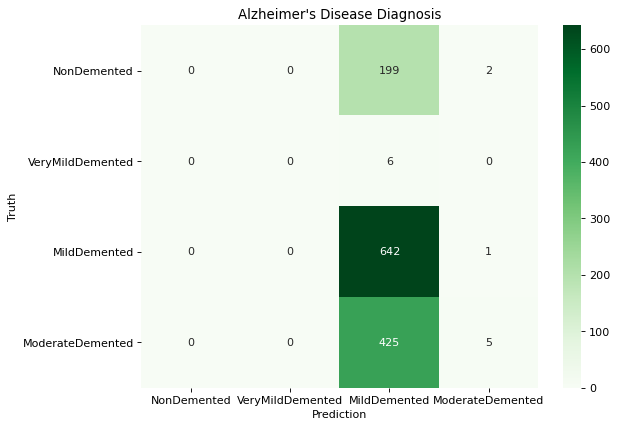

In [34]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [35]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 25.25 %
Matthew's Correlation Coefficient: 4.78 %


In [28]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

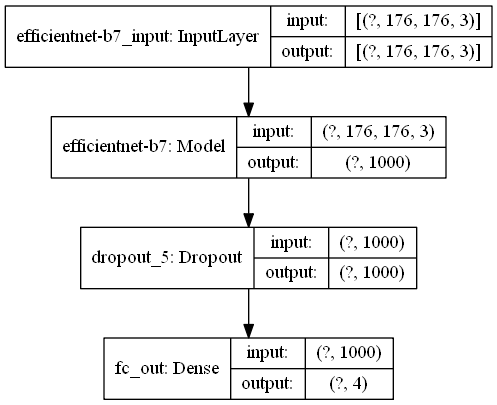

In [29]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
visualkeras.layered_view(model, to_file=work_dir + 'output.png') # write to disk